In [1]:
# General libraries
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Deep learning libraries
import tensorflow.keras.backend as K
import tensorflow as tf

# Setting seeds for reproducibility
seed = 232
np.random.seed(seed)
tf.set_random_seed(seed)
from tensorflow.compat.v1 import ConfigProto,InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True 
config.gpu_options.per_process_gpu_memory_fraction = 0.9
session = InteractiveSession(config=config)
#tf.keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

In [2]:
from tensorflow.keras.models import load_model
model = load_model("../outputs/resnet")
#model.load_weights("../outputs/main_heatmap_weight.hdf5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [3]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [23]:
from skimage import data, color, io, img_as_float
from skimage import filters
def get_heatmap(processed_image, class_idx):
    # we want the activations for the predicted label
    class_output = model.output[:, class_idx]
    
    # choose the last conv layer in your model
    last_conv_layer = model.get_layer("post_relu")
    # get the gradients wrt to the last conv layer
    
    grads = K.gradients(class_output, last_conv_layer.output)[0]
   # we pool the gradients over all the axes leaving out the channel dimension
    pooled_grads = K.mean(grads, axis=(0,1,2))
    print(pooled_grads)
    # Define a function that generates the values for the output and gradients
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    
    # get the values
    grads_values, conv_ouput_values = iterate([processed_image])
    
    # iterate over each feature map in your conv output and multiply
    # the gradient values with the conv output values. This gives an 
    # indication of "how important a feature is"
    nv = grads_values.shape[0]
    for i in range(nv):
        conv_ouput_values[:,:,i] *= grads_values[i]
    
    # create a heatmap
    heatmap = np.mean(conv_ouput_values, axis=-1)
    
    # remove negative values
    heatmap = np.maximum(heatmap, 0)
    
    # normalize
    heatmap /= heatmap.max()
    
    return heatmap

In [24]:
def pre(sample_image,model):
    sample_image = cv2.resize(sample_image, (150,150))
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    sample_image = sample_image.astype(np.float32)/255.
    sample_label = 1
    sample_image_processed = np.expand_dims(sample_image, axis=0)
    pred_label =[]
    pred_label = model.predict(sample_image_processed)
    pred_label = list(pred_label[0]).index(max(pred_label[0]))
    return pred_label,sample_image,sample_image_processed

In [25]:
def heatm(pred_label,sample_image,sample_image_processed):
    # get the heatmap for class activation map(CAM)
    heatmap = get_heatmap(sample_image_processed, pred_label)
    heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
    heatmap = heatmap *255
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_RAINBOW)
    #superimpose the heatmap on the image    

    sample_image_hsv = color.rgb2hsv(sample_image)
    heatmap = color.rgb2hsv(heatmap)

    alpha=.9
    sample_image_hsv[..., 0] = heatmap[..., 0]
    sample_image_hsv[..., 1] = heatmap[..., 1] * alpha

    img_masked = color.hsv2rgb(sample_image_hsv)
    return img_masked

In [26]:
from glob import glob #retriving an array of files in directories
path_test = "../proc_input/covid_data/test/"
dis = ["NORMAL","PNEUMONIA","COVID"]
num = 5

Tensor("Mean_56:0", shape=(2048,), dtype=float32)
Tensor("Mean_57:0", shape=(2048,), dtype=float32)
Tensor("Mean_58:0", shape=(2048,), dtype=float32)
Tensor("Mean_59:0", shape=(2048,), dtype=float32)
Tensor("Mean_60:0", shape=(2048,), dtype=float32)
Tensor("Mean_61:0", shape=(2048,), dtype=float32)
Tensor("Mean_62:0", shape=(2048,), dtype=float32)


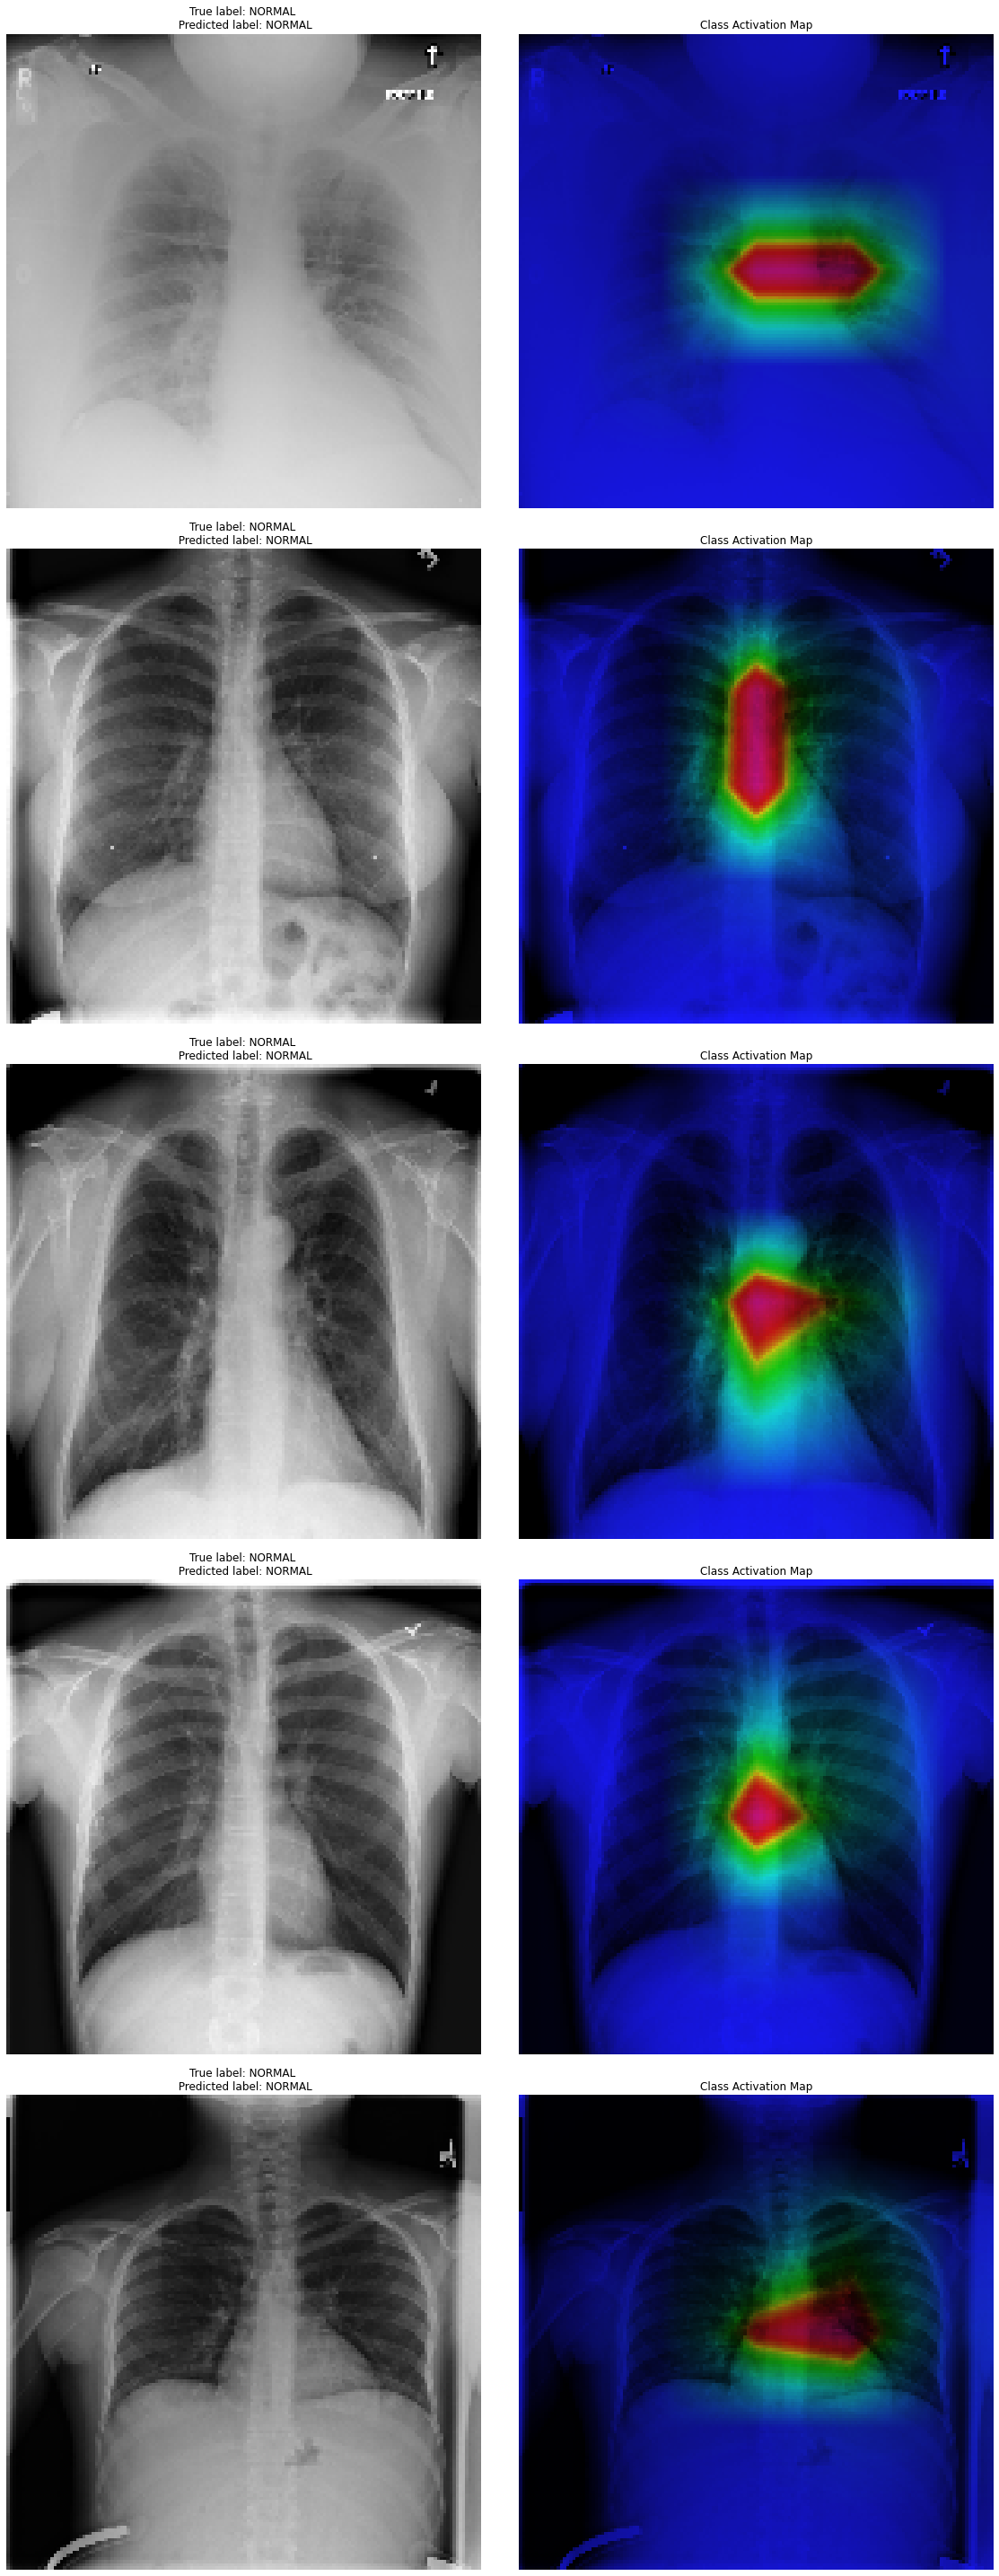

In [28]:
#NORMAL HEATMAP
img = glob(path_test+dis[0]+"/*.jpg")
random.shuffle(img)
count = 0
f,ax = plt.subplots(num,2, figsize=(16,40))
ax = ax.ravel()
plt.tight_layout()
i = 0
for sample_image in img:
    sample_image = plt.imread(sample_image)
    pred_label,sample_image1,sample_image_processed = pre(sample_image,model)
    img_masked = heatm(pred_label,sample_image1,sample_image_processed)
    if(dis[0] == dis[pred_label]):
        ax[i].imshow(sample_image1)
        ax[i].set_title(f"True label: {dis[0]} \n Predicted label: {dis[pred_label]}")
        ax[i].axis('off')
        i+=1
        ax[i].imshow(img_masked)
        ax[i].set_title("Class Activation Map")
        ax[i].axis('off')
        i+=1
        count += 1
        if(count == num):
            break  
plt.show()

Tensor("Mean_63:0", shape=(2048,), dtype=float32)
Tensor("Mean_64:0", shape=(2048,), dtype=float32)
Tensor("Mean_65:0", shape=(2048,), dtype=float32)
Tensor("Mean_66:0", shape=(2048,), dtype=float32)
Tensor("Mean_67:0", shape=(2048,), dtype=float32)
Tensor("Mean_68:0", shape=(2048,), dtype=float32)
Tensor("Mean_69:0", shape=(2048,), dtype=float32)
Tensor("Mean_70:0", shape=(2048,), dtype=float32)
Tensor("Mean_71:0", shape=(2048,), dtype=float32)
Tensor("Mean_72:0", shape=(2048,), dtype=float32)


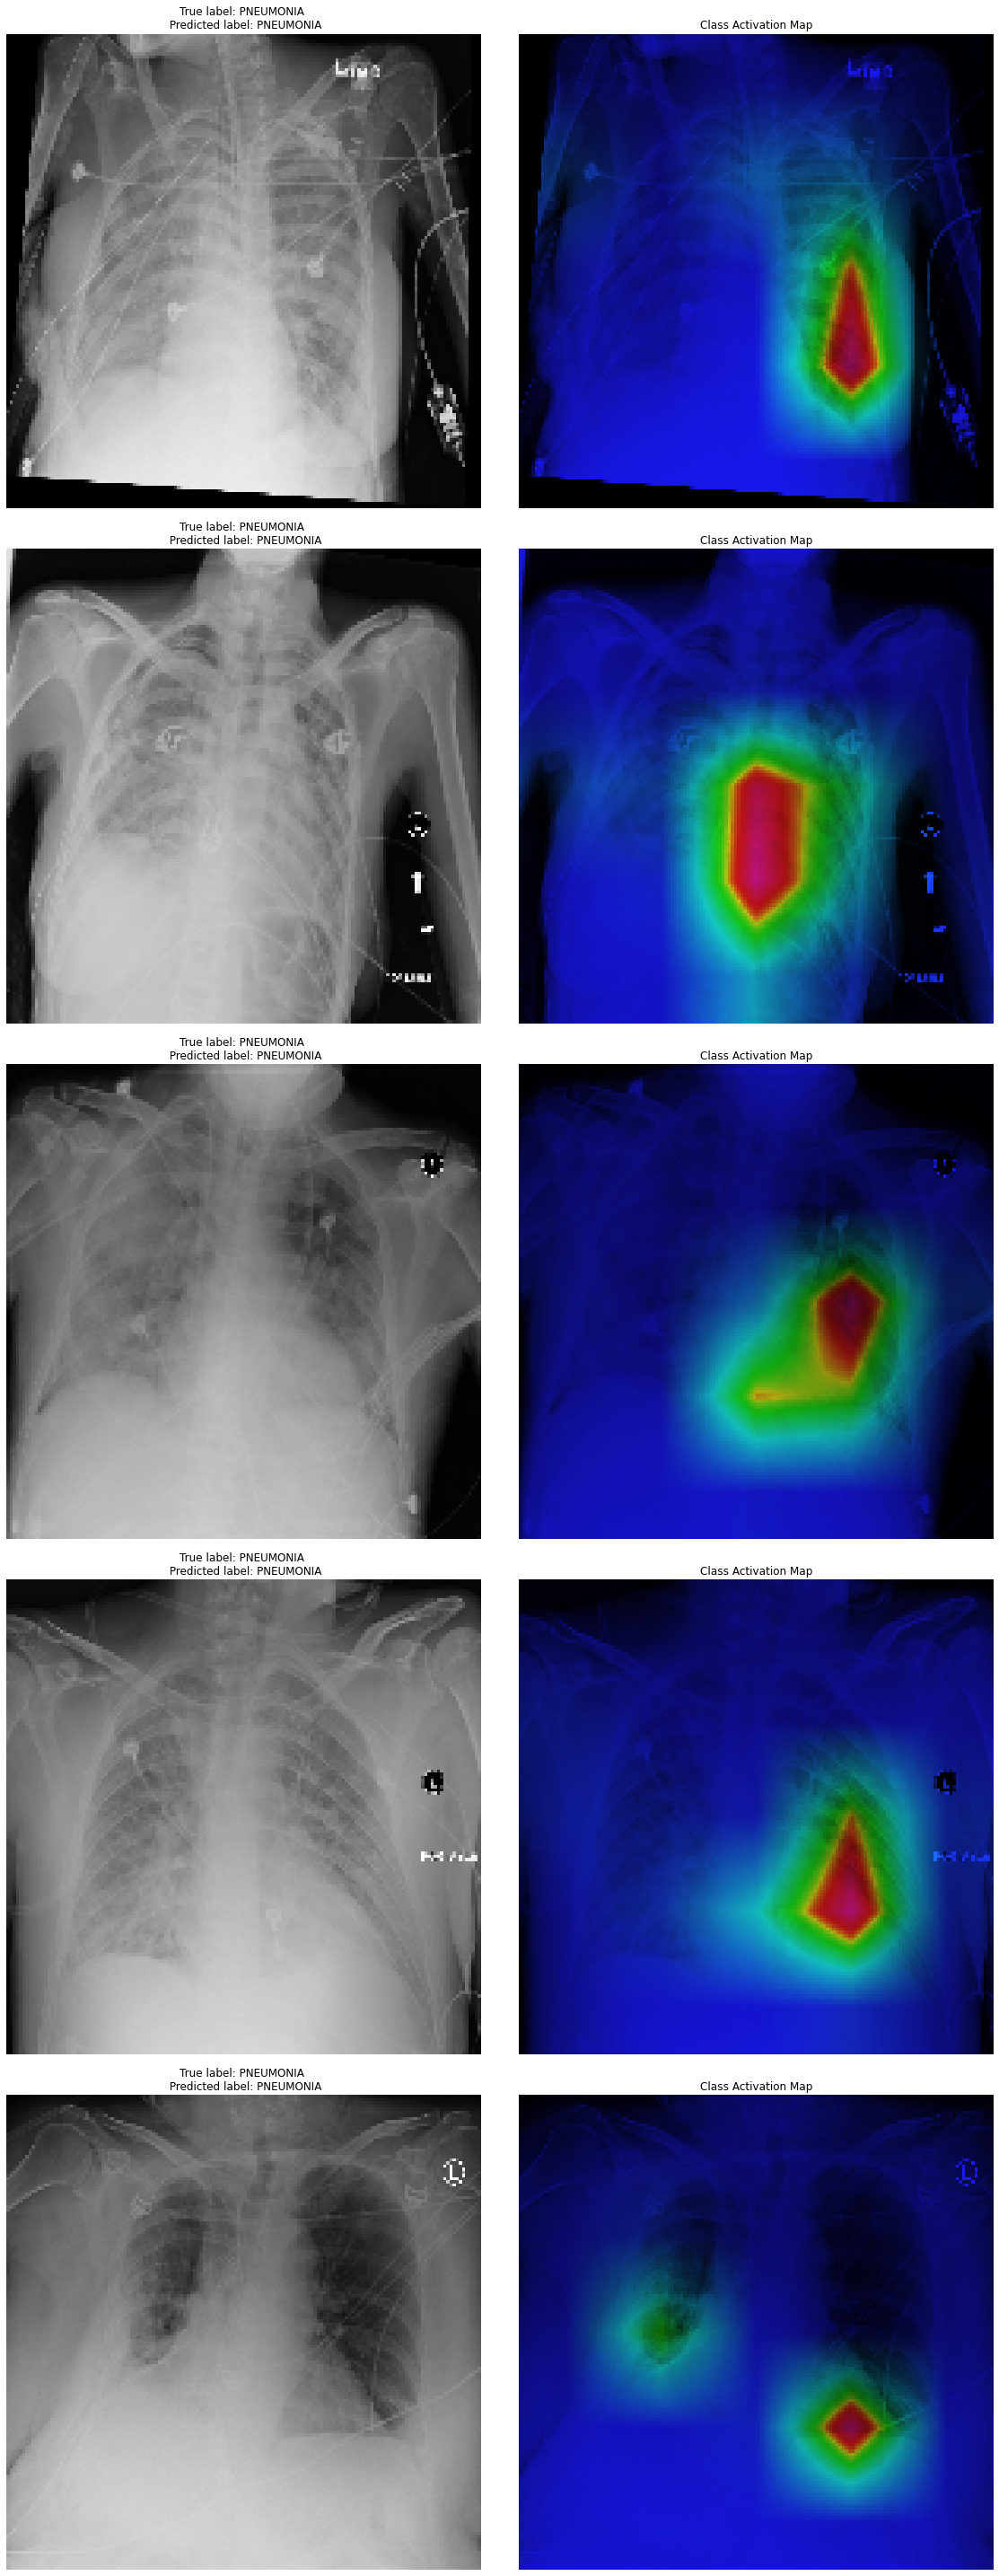

In [29]:
#PNEUMONIA HEATMAP
img = glob(path_test+dis[1]+"/*.jpg")
random.shuffle(img)
count = 0
f,ax = plt.subplots(num,2, figsize=(16,40))
ax = ax.ravel()
plt.tight_layout()
i = 0
for sample_image in img:
    sample_image = plt.imread(sample_image)
    pred_label,sample_image1,sample_image_processed = pre(sample_image,model)
    img_masked = heatm(pred_label,sample_image1,sample_image_processed)
    if(dis[1] == dis[pred_label]):
        ax[i].imshow(sample_image1)
        ax[i].set_title(f"True label: {dis[1]} \n Predicted label: {dis[pred_label]}")
        ax[i].axis('off')
        i+=1
        ax[i].imshow(img_masked)
        ax[i].set_title("Class Activation Map")
        ax[i].axis('off')
        i+=1
        count += 1
        if(count == num):
            break  
plt.show()

Tensor("Mean_73:0", shape=(2048,), dtype=float32)
Tensor("Mean_74:0", shape=(2048,), dtype=float32)
Tensor("Mean_75:0", shape=(2048,), dtype=float32)
Tensor("Mean_76:0", shape=(2048,), dtype=float32)
Tensor("Mean_77:0", shape=(2048,), dtype=float32)
Tensor("Mean_78:0", shape=(2048,), dtype=float32)


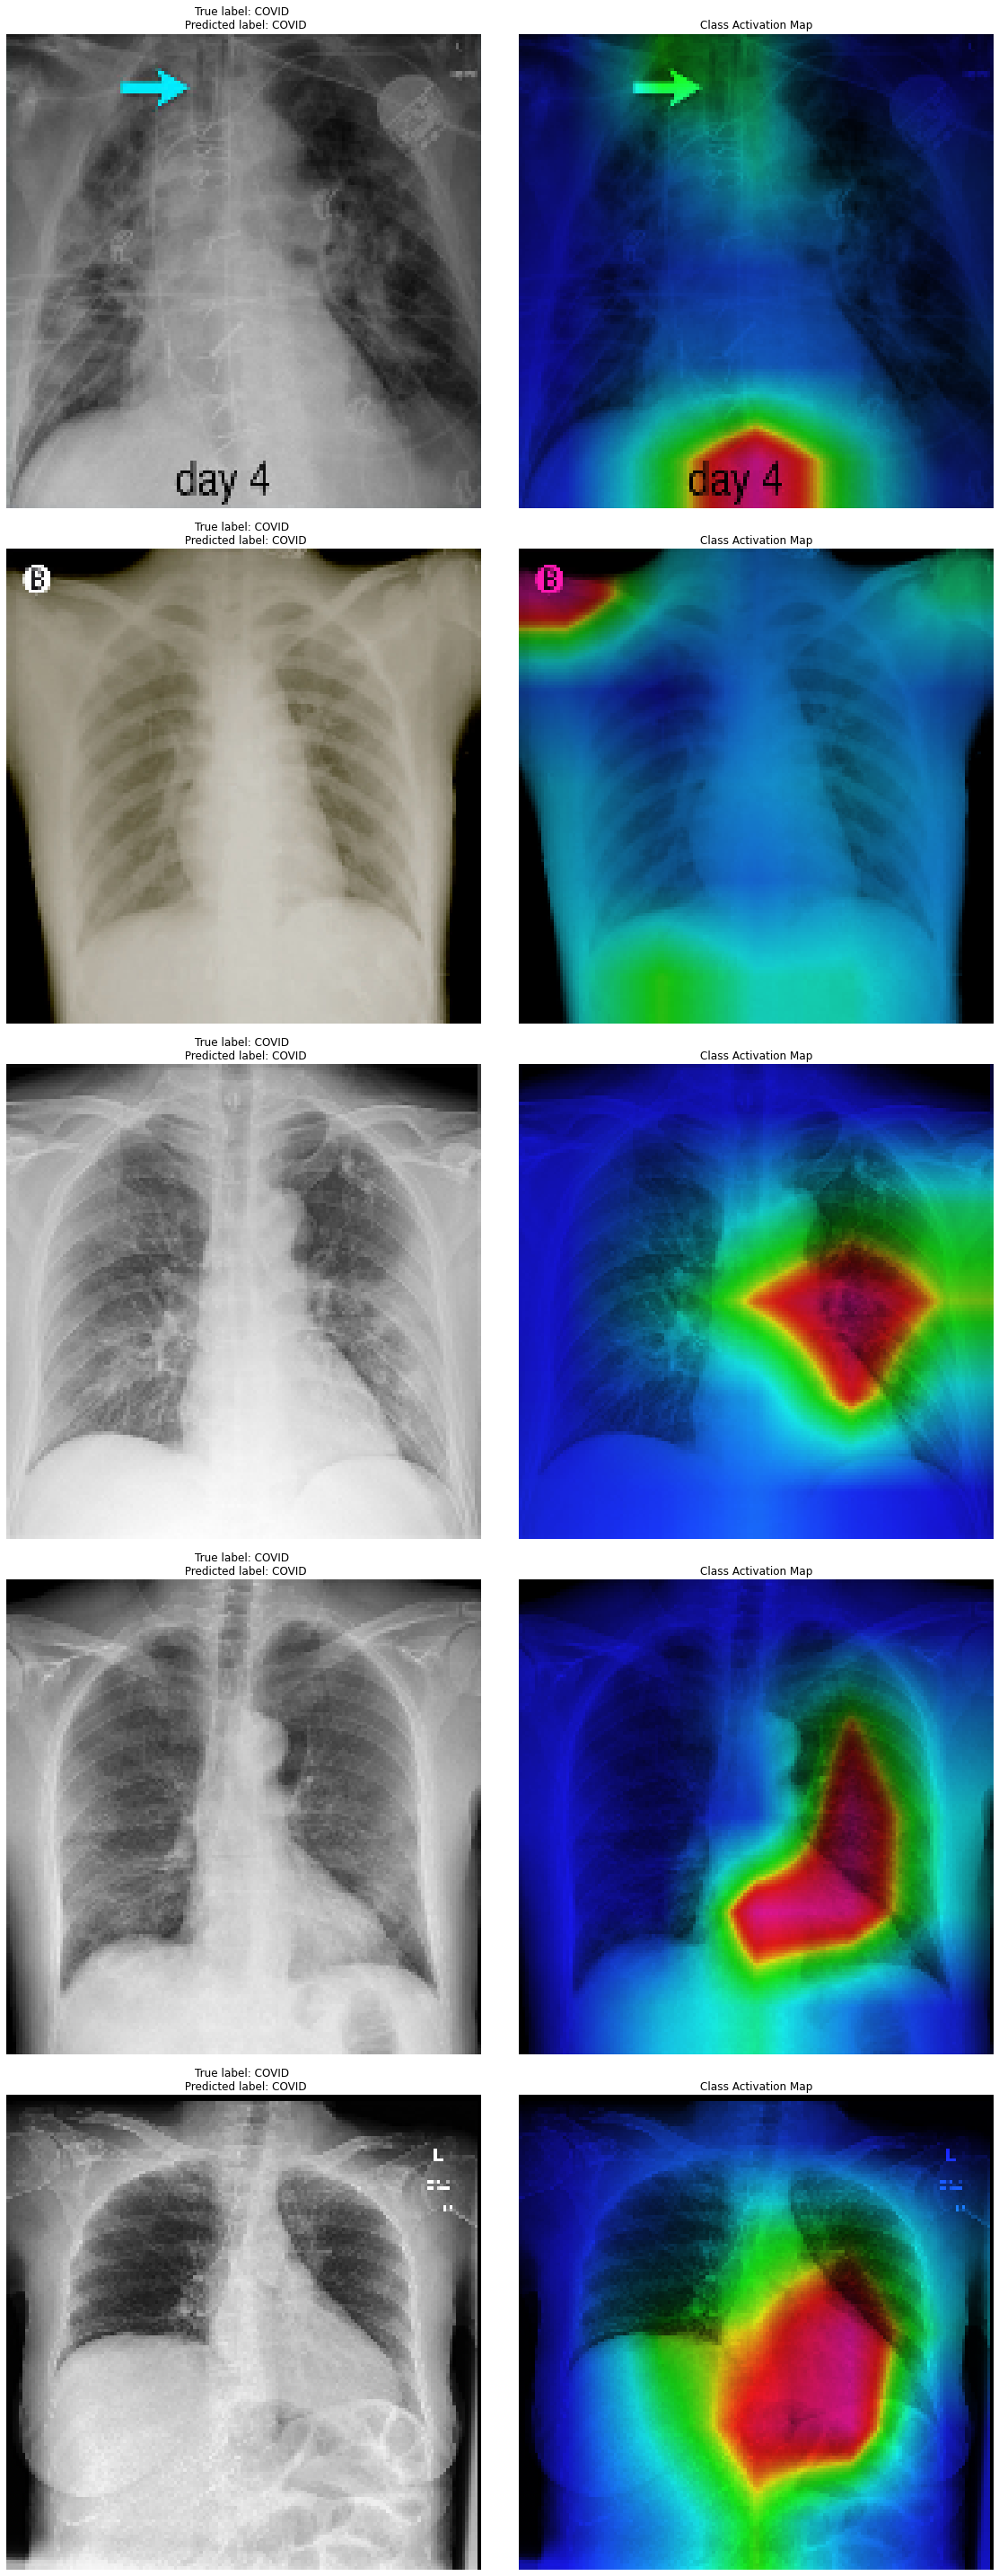

In [30]:
#COVID HEATMAP
img = glob(path_test+dis[2]+"/*.jpg")
random.shuffle(img)
count = 0
f,ax = plt.subplots(num,2, figsize=(16,40))
ax = ax.ravel()
plt.tight_layout()
i = 0
for sample_image in img:
    sample_image = plt.imread(sample_image)
    pred_label,sample_image1,sample_image_processed = pre(sample_image,model)
    img_masked = heatm(pred_label,sample_image1,sample_image_processed)
    if(dis[2] == dis[pred_label]):
        ax[i].imshow(sample_image1)
        ax[i].set_title(f"True label: {dis[2]} \n Predicted label: {dis[pred_label]}")
        ax[i].axis('off')
        i+=1
        ax[i].imshow(img_masked)
        ax[i].set_title("Class Activation Map")
        ax[i].axis('off')
        i+=1
        count += 1
        if(count == num):
            break  
plt.show()